# Web Scraping Project - Airbnb 

### Import libraries

In [103]:
# imports
import pandas as pd
from bs4 import BeautifulSoup # For HTML parsing
import requests # Website connections
from time import sleep # To prevent overwhelming the server between connections
from collections import Counter # Keep track of our term counts
import pandas as pd # For converting results to a dataframe and bar chart plots
import json # For parsing json

In [173]:
import numpy as np
import matplotlib.pyplot as plt # Data Visualization
%matplotlib inline

### Get the html code for every listings on the webpage
- Example city: Totonto; Date: 2021.10.25- 2021.10.29 (weekday); Guest: not specified

In [104]:
def get_page(page_url):
    result =requests.get(page_url)
    content = result.content
    soup = BeautifulSoup(content, 'html.parser')
    listings = soup.find_all('div', class_ = '_8s3ctt') # Every listing has the same tag and class name
    return listings

In [108]:
airbnb_url = 'https://www.airbnb.ca/s/Toronto--ON/homes?tab_id=home_tab&refinement_paths%5B%5D=%2Fhomes&flexible_trip_dates%5B%5D=november&flexible_trip_dates%5B%5D=october&flexible_trip_lengths%5B%5D=weekend_trip&date_picker_type=calendar&query=Toronto%2C%20ON&place_id=ChIJpTvG15DL1IkRd8S0KlBVNTI&checkin=2021-10-25&checkout=2021-10-29&source=structured_search_input_header&search_type=autocomplete_click'

In [109]:
listings = get_page(airbnb_url)

### Airbnb website contains 20 listings per page

In [110]:
len(listings)

20

In [111]:
print(listings[0].prettify())

<div aria-labelledby="title_52826732" class="_8s3ctt" role="group">
 <a aria-labelledby="title_52826732" class="_mm360j" href="/rooms/52826732?check_in=2021-10-25&amp;check_out=2021-10-29&amp;previous_page_section_name=1000&amp;translate_ugc=false&amp;federated_search_id=709e34d1-427d-4a2a-a054-c8c446861b95" rel="noopener noreferrer" target="listing_52826732">
 </a>
 <div class="_1nz9l7j">
  <div class="_bp2sgw9" style="--listing-card-media-border-radius:12px">
   <div class="_1mx6kqf" style="background:var(--d-nc-lt-s);--dls-basecard-padding-top:66.6667%">
    <div class="_1szwzht">
     <div class="_v0gz4uz" style="--dls-liteimage-padding-top:66.6667%">
      <div class="_4626ulj">
       <picture>
        <source media="(max-width: 743px)" srcset="https://a0.muscache.com/im/pictures/b19ab832-6818-4e9f-ac2d-1d809f830f7e.jpg?im_w=480 1x"/>
        <source media="(min-width: 743.1px) and (max-width: 1127px)" srcset="https://a0.muscache.com/im/pictures/b19ab832-6818-4e9f-ac2d-1d809f830f

### Create a dictionary that indicates elements' position

In [112]:
page_elements = {
    'url': {'tag':'a', 'get':'href'},
    'name': {'tag':'span', 'class':'_1whrsux9'},
    'header': {'tag':'div', 'class':'_1xzimiid'},
    'rooms': {'tag':'div', 'class':'_3c0zz1', 'order':0},
    'facilities': {'tag':'div', 'class':'_3c0zz1', 'order':1},
    'rating': {'tag':'span', 'class':'_18khxk1'},
    'price': {'tag':'span', 'class':'a8jt5op dir dir-ltr'},
    'superhost':{'tag':'div', 'class':'_1u0inz4'}
}

### Find the elements
- Find the tag
- Find the right position/order
- Get text
- Error means that element does not exist in this listing

In [113]:
def get_elements(html, elements):
    if 'class' in elements:
        data = html.find_all(elements['tag'],elements['class'])
    else:
        data = html.find_all(elements['tag'])
    
    order = elements.get('order',0)
    element = data[order]
    
    if 'get' in elements:
        output = element.get(elements['get'])
    else:
        output = element.get_text()
        
    return output

In [114]:
get_elements(listings[0], page_elements['url'])

'/rooms/52826732?check_in=2021-10-25&check_out=2021-10-29&previous_page_section_name=1000&translate_ugc=false&federated_search_id=709e34d1-427d-4a2a-a054-c8c446861b95'

In [115]:
get_elements(listings[0], page_elements['name'])

'Spacious and clean one bedroom'

In [116]:
get_elements(listings[0], page_elements['header'])

'Entire rental unit in Dovercourt Park'

In [117]:
get_elements(listings[0], page_elements['rooms'])

'2 guests · 1 bedroom · 1 bed · 1 bath'

In [118]:
get_elements(listings[0], page_elements['facilities'])

'Wifi · Air conditioning'

In [119]:
get_elements(listings[0], page_elements['rating'])

IndexError: list index out of range

In [120]:
get_elements(listings[0], page_elements['price'])

'$84 CAD per night'

In [121]:
get_elements(listings[0], page_elements['superhost'])

IndexError: list index out of range

### Get all elements for every listing
- Try&except aviod errors
- Put 'empty' if element does not exist

In [122]:
def get_all_elements(soup, elements):
    listings_dict = {}
    for element in elements:
        try:
            listings_dict[element] = get_elements(soup, elements[element])
        except:
            listings_dict[element] = 'empty'
    return listings_dict

In [123]:
get_all_elements(listings[0], page_elements)

{'url': '/rooms/52826732?check_in=2021-10-25&check_out=2021-10-29&previous_page_section_name=1000&translate_ugc=false&federated_search_id=709e34d1-427d-4a2a-a054-c8c446861b95',
 'name': 'Spacious and clean one bedroom',
 'header': 'Entire rental unit in Dovercourt Park',
 'rooms': '2 guests · 1 bedroom · 1 bed · 1 bath',
 'facilities': 'Wifi · Air conditioning',
 'rating': 'empty',
 'price': '$84 CAD per night',
 'superhost': 'empty'}

### Get url lists for every page
- Url has pattern
- Airbnb only respond back 15 pages per search, which contains max 300 listings (usually 200+).

In [ ]:
#Page1: https://www.airbnb.ca/s/Toronto--ON/homes?tab_id=home_tab&refinement_paths%5B%5D=%2Fhomes&flexible_trip_dates%5B%5D=november&flexible_trip_dates%5B%5D=october&flexible_trip_lengths%5B%5D=weekend_trip&date_picker_type=calendar&query=Toronto%2C%20ON&place_id=ChIJpTvG15DL1IkRd8S0KlBVNTI&checkin=2021-10-25&checkout=2021-10-29&source=structured_search_input_header&search_type=autocomplete_click
#Page2: https://www.airbnb.ca/s/Toronto--ON/homes?tab_id=home_tab&refinement_paths%5B%5D=%2Fhomes&flexible_trip_dates%5B%5D=november&flexible_trip_dates%5B%5D=october&flexible_trip_lengths%5B%5D=weekend_trip&date_picker_type=calendar&query=Toronto%2C%20ON&place_id=ChIJpTvG15DL1IkRd8S0KlBVNTI&checkin=2021-10-25&checkout=2021-10-29&source=structured_search_input_header&search_type=autocomplete_click&federated_search_session_id=c8f0fd79-c862-421f-83ee-a1c2769ec013&pagination_search=true&items_offset=20&section_offset=2
#Page3: https://www.airbnb.ca/s/Toronto--ON/homes?tab_id=home_tab&refinement_paths%5B%5D=%2Fhomes&flexible_trip_dates%5B%5D=november&flexible_trip_dates%5B%5D=october&flexible_trip_lengths%5B%5D=weekend_trip&date_picker_type=calendar&query=Toronto%2C%20ON&place_id=ChIJpTvG15DL1IkRd8S0KlBVNTI&checkin=2021-10-25&checkout=2021-10-29&source=structured_search_input_header&search_type=autocomplete_click&federated_search_session_id=c8f0fd79-c862-421f-83ee-a1c2769ec013&pagination_search=true&items_offset=40&section_offset=2

In [124]:
def list_urls(url):
    url_list = []
    for i in range(15):
        x = 20*i
        urls = url + f'&federated_search_session_id=c8f0fd79-c862-421f-83ee-a1c2769ec013&pagination_search=true&items_offset={x}&section_offset=2'
        url_list.append(urls)
    return url_list

In [125]:
list_urls(airbnb_url)

['https://www.airbnb.ca/s/Toronto--ON/homes?tab_id=home_tab&refinement_paths%5B%5D=%2Fhomes&flexible_trip_dates%5B%5D=november&flexible_trip_dates%5B%5D=october&flexible_trip_lengths%5B%5D=weekend_trip&date_picker_type=calendar&query=Toronto%2C%20ON&place_id=ChIJpTvG15DL1IkRd8S0KlBVNTI&checkin=2021-10-25&checkout=2021-10-29&source=structured_search_input_header&search_type=autocomplete_click&federated_search_session_id=c8f0fd79-c862-421f-83ee-a1c2769ec013&pagination_search=true&items_offset=0&section_offset=2',
 'https://www.airbnb.ca/s/Toronto--ON/homes?tab_id=home_tab&refinement_paths%5B%5D=%2Fhomes&flexible_trip_dates%5B%5D=november&flexible_trip_dates%5B%5D=october&flexible_trip_lengths%5B%5D=weekend_trip&date_picker_type=calendar&query=Toronto%2C%20ON&place_id=ChIJpTvG15DL1IkRd8S0KlBVNTI&checkin=2021-10-25&checkout=2021-10-29&source=structured_search_input_header&search_type=autocomplete_click&federated_search_session_id=c8f0fd79-c862-421f-83ee-a1c2769ec013&pagination_search=true&

In [126]:
url_lists = list_urls(airbnb_url)

### Get data from all pages
- Include sleep to prevent block

In [127]:
def get_all_pages(url_lists):
    page_list = []
    for url in url_lists:
        listings = get_page(url)
        sleep(3)
        for listing in listings:
            elements = get_all_elements(listing, page_elements)
            page_list.append(elements)
    return page_list

In [128]:
weekday = get_all_pages(url_lists)

### Convert data to dataframe and save as CSV file
- Easy to manipulate data

In [129]:
pd.DataFrame(weekday).to_csv('weekday.csv', index = False)

In [135]:
weekday_list = pd.DataFrame(weekday)

### Get more data and remove duplicates 
- Because Airbnb only has 15 pages per search, which means when user search again, the results could be different. 
- So I ran the above function multiple times and stored data in different CSV files, in order to get as more data as possible.
- Remove duplicates by: 
####  df3 = pd.concat([df1,df2], ignore_index=True).drop_duplicates().reset_index(drop=True)

### Get data for the same city but different time period
- city: Totonto; Date: 2021.10.30- 2021.10.31 (weekend); Guest: not specified

In [130]:
weekend_url = 'https://www.airbnb.ca/s/Toronto--ON/homes?tab_id=home_tab&refinement_paths%5B%5D=%2Fhomes&flexible_trip_dates%5B%5D=november&flexible_trip_dates%5B%5D=october&flexible_trip_lengths%5B%5D=weekend_trip&date_picker_type=calendar&query=Toronto%2C%20ON&place_id=ChIJpTvG15DL1IkRd8S0KlBVNTI&checkin=2021-10-30&checkout=2021-10-31&source=structured_search_input_header&search_type=filter_change'

In [131]:
len(get_page(weekend_url))

20

In [132]:
weekend_list = list_urls(weekend_url)

In [133]:
weekend = get_all_pages(weekend_list)

In [134]:
pd.DataFrame(weekend).to_csv('weekend.csv', index = False)

In [136]:
weekend_list = pd.DataFrame(weekend)

### Convert price(string) to integer

In [154]:
weekday_list['price']

0                      $196 CAD per night
1                       $84 CAD per night
2                      $124 CAD per night
3                       $54 CAD per night
4                      $127 CAD per night
                      ...                
195                     $56 CAD per night
196                     $63 CAD per night
197                    $295 CAD per night
198    $99 CAD per night, originally $114
199                    $119 CAD per night
Name: price, Length: 200, dtype: object

In [159]:
int_price = []
for x in weekday_list['price']:
    try:
        y = int(x.replace('$','').split()[0])
    except:
        y = None
    int_price.append(y)
int_price

[196,
 84,
 124,
 54,
 127,
 177,
 90,
 85,
 None,
 None,
 94,
 140,
 256,
 91,
 181,
 237,
 105,
 209,
 86,
 123,
 120,
 193,
 112,
 184,
 193,
 87,
 38,
 227,
 159,
 235,
 86,
 114,
 202,
 None,
 234,
 243,
 130,
 214,
 64,
 79,
 232,
 235,
 217,
 160,
 69,
 112,
 None,
 234,
 202,
 200,
 188,
 None,
 None,
 343,
 242,
 209,
 239,
 184,
 318,
 234,
 184,
 235,
 75,
 364,
 71,
 None,
 118,
 76,
 109,
 329,
 121,
 318,
 331,
 205,
 307,
 392,
 150,
 225,
 154,
 246,
 75,
 183,
 73,
 141,
 65,
 183,
 157,
 236,
 71,
 76,
 364,
 460,
 108,
 259,
 229,
 277,
 182,
 294,
 93,
 120,
 263,
 440,
 63,
 75,
 120,
 93,
 196,
 294,
 58,
 297,
 376,
 102,
 277,
 183,
 124,
 63,
 135,
 312,
 None,
 343,
 70,
 108,
 229,
 418,
 104,
 318,
 119,
 278,
 283,
 342,
 157,
 61,
 102,
 183,
 178,
 295,
 271,
 80,
 None,
 280,
 499,
 212,
 268,
 194,
 135,
 83,
 120,
 286,
 104,
 252,
 196,
 460,
 908,
 272,
 100,
 233,
 61,
 65,
 295,
 130,
 215,
 97,
 63,
 116,
 344,
 250,
 228,
 186,
 100,
 121,
 194,


In [163]:
weekday_list['price_num'] = int_price

### Calculate the average price in weekday

In [166]:
weekday_list['price_num'].mean()

193.24338624338625

### Calculate the number of superhost in weekday

In [170]:
weekday_list['superhost'].value_counts()

empty        125
SUPERHOST     72
PLUS           3
Name: superhost, dtype: int64

### Convert rooms(string) to number of bedroom(integer)

In [185]:
bedroom = []
for x in weekday_list['rooms']:
    try:
        y = int(x.split(' · ')[1].split()[0])
    except:
        y = None
    bedroom.append(y)
bedroom

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 None,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 None,
 1,
 1,
 None,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 None,
 1,
 1,
 1,
 1,
 None,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 3,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 3,
 1,
 3,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 3,
 1,
 2,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 None,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 3,
 2,
 3,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 5,
 1,
 None,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 None,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 None,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1]

In [186]:
weekday_list['bedrooms'] = bedroom

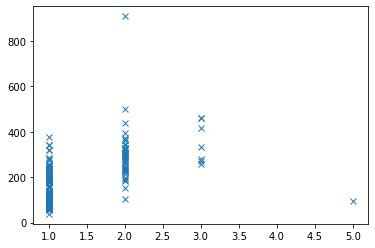

In [191]:
plt.plot(weekday_list['bedrooms'],weekday_list['price_num'], 'x');

### Convert guest(string) to number of guest allowed(integer)

In [192]:
guest = []
for x in weekday_list['rooms']:
    try:
        y = int(x.split(' · ')[0].split()[0])
    except:
        y = None
    guest.append(y)
guest

[3,
 2,
 2,
 1,
 1,
 3,
 2,
 2,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 5,
 2,
 4,
 1,
 2,
 2,
 2,
 2,
 4,
 4,
 2,
 1,
 5,
 4,
 2,
 1,
 2,
 2,
 6,
 2,
 2,
 3,
 2,
 2,
 2,
 6,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 4,
 2,
 6,
 3,
 4,
 4,
 5,
 6,
 2,
 4,
 6,
 2,
 2,
 4,
 2,
 2,
 3,
 2,
 1,
 6,
 2,
 2,
 6,
 2,
 4,
 4,
 3,
 4,
 5,
 6,
 2,
 3,
 1,
 4,
 1,
 3,
 4,
 4,
 1,
 2,
 4,
 10,
 1,
 7,
 2,
 3,
 3,
 4,
 1,
 4,
 4,
 5,
 3,
 2,
 4,
 1,
 2,
 4,
 2,
 4,
 3,
 2,
 3,
 3,
 2,
 2,
 4,
 4,
 5,
 6,
 2,
 1,
 3,
 6,
 2,
 5,
 1,
 6,
 2,
 5,
 4,
 2,
 1,
 3,
 2,
 4,
 4,
 2,
 4,
 4,
 6,
 3,
 3,
 4,
 4,
 1,
 4,
 5,
 3,
 5,
 2,
 10,
 5,
 6,
 3,
 6,
 1,
 1,
 4,
 2,
 4,
 5,
 2,
 2,
 5,
 4,
 4,
 2,
 4,
 1,
 5,
 5,
 2,
 2,
 6,
 2,
 4,
 6,
 6,
 4,
 1,
 2,
 6,
 2,
 4,
 4,
 4,
 4,
 2,
 2,
 3,
 5,
 4,
 1,
 2,
 1,
 3,
 4,
 1,
 4]

### Calculate the average price in weekend

In [167]:
num_price = []
for x in weekend_list['price']:
    try:
        y = int(x.replace('$','').split()[0])
    except:
        y = None
    num_price.append(y)
num_price

[62,
 118,
 122,
 None,
 118,
 147,
 619,
 504,
 130,
 76,
 130,
 324,
 115,
 407,
 202,
 131,
 83,
 163,
 200,
 613,
 123,
 102,
 89,
 106,
 163,
 383,
 141,
 200,
 106,
 152,
 197,
 136,
 136,
 121,
 608,
 235,
 431,
 187,
 187,
 106,
 98,
 94,
 350,
 504,
 90,
 312,
 608,
 168,
 86,
 502,
 93,
 129,
 66,
 360,
 150,
 502,
 509,
 611,
 207,
 123,
 123,
 129,
 84,
 201,
 126,
 509,
 158,
 94,
 312,
 183,
 117,
 502,
 187,
 608,
 88,
 502,
 298,
 74,
 94,
 141,
 196,
 199,
 163,
 322,
 518,
 419,
 187,
 502,
 82,
 148,
 74,
 290,
 92,
 70,
 92,
 86,
 117,
 117,
 148,
 203,
 608,
 85,
 82,
 354,
 608,
 395,
 122,
 518,
 133,
 93,
 135,
 68,
 371,
 210,
 132,
 203,
 132,
 198,
 117,
 436,
 198,
 608,
 103,
 83,
 197,
 91,
 90,
 164,
 288,
 142,
 342,
 96,
 293,
 177,
 92,
 187,
 96,
 92,
 114,
 282,
 139,
 114,
 100,
 148,
 114,
 100,
 33,
 147,
 293,
 111,
 187,
 187,
 290,
 210,
 106,
 103,
 97,
 98,
 97,
 140]

In [168]:
weekend_list['price_num'] = num_price

In [169]:
weekend_list['price_num'].mean()

212.8238993710692

### Calculate the number of superhost in weekend

In [171]:
weekend_list['superhost'].value_counts()

empty        125
SUPERHOST     35
Name: superhost, dtype: int64

In [3]:
BeautifulSoup?